# <span style="color:#00525f;"> Importing Libraries </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import warnings
warnings.simplefilter("ignore")

# <span style="color:#00525f;"> Loading up the data </span>

In [2]:
import sqlite3
con = sqlite3.connect("../labelig_website/db.sqlite3")
data = pd.read_sql_query("SELECT * from label_sms", con)
con.close()
data.drop(columns=['id'])
data = data[["label", "text"]]
data = data.rename(columns={"label": "Category", "text": "Message"})

In [3]:
data.head()

,Category,Message
0,spam,یک عکس از طرف مهرداد میناوند برای شما ارسال شد...
1,ham,دوتومن برداشتم بهش برخورده! هعی اس ام اس\r\nمی...
2,ham,&number
3,ham,"مشترک گرامی, درخواست شما با موفقیت ثبت شد. سام..."
4,ham,کاربر گرامي سفارش &english-&number پردازش و آ...


In [4]:
data.describe().T

,count,unique,top,freq
Category,2910,2,spam,1737
Message,2910,2910,یک عکس از طرف مهرداد میناوند برای شما ارسال شد...,1


In [5]:
data.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         1173   1173  دوتومن برداشتم بهش برخورده! هعی اس ام اس\r\nمی...   
spam        1737   1737  یک عکس از طرف مهرداد میناوند برای شما ارسال شد...   

               
         freq  
Category       
ham         1  
spam        1

In [6]:
data["Length"] = data["Message"].apply(len)

In [7]:
data["Spam"] = data["Category"].apply(lambda x: 1 if x=="spam" else 0)

In [8]:
data.head()

,Category,Message,Length,Spam
0,spam,یک عکس از طرف مهرداد میناوند برای شما ارسال شد...,130,1
1,ham,دوتومن برداشتم بهش برخورده! هعی اس ام اس\r\nمی...,68,0
2,ham,&number,7,0
3,ham,"مشترک گرامی, درخواست شما با موفقیت ثبت شد. سام...",91,0
4,ham,کاربر گرامي سفارش &english-&number پردازش و آ...,198,0


# <span style="color:#00525f;"> analyzing dataset characteristics </span>

In [9]:
# def custom_palette(custom_colors):
#     customPalette = sns.set_palette(sns.color_palette(custom_colors))
#     sns.palplot(sns.color_palette(custom_colors),size=0.8)
#     plt.tick_params(axis='both', labelsize=0, length = 0)

In [10]:
pal = ["#a40a71","#00524a", "#3a4856"]
# custom_palette(pal)

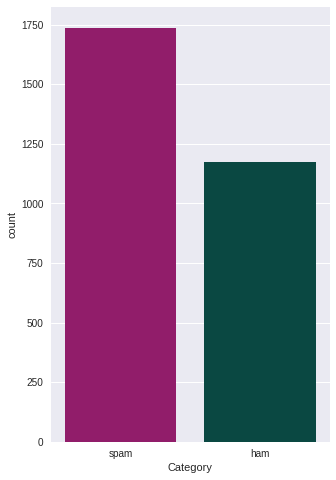

In [11]:
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(5,8))
sns.countplot(x = data.Category, palette=pal)
plt.show()

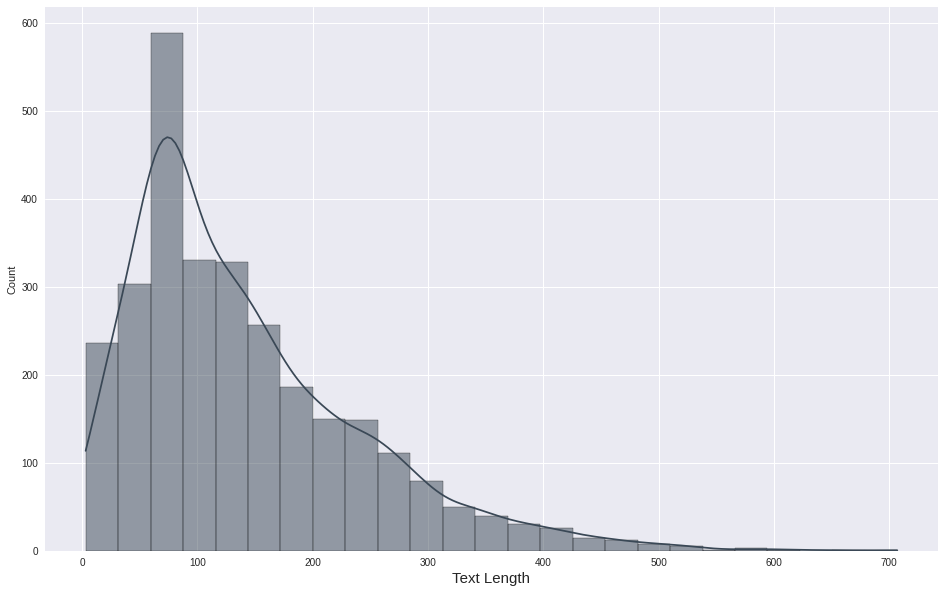

In [12]:
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(16,10))
sns.histplot(x = data["Length"], kde=True, color=pal[2], bins=25);
plt.xlabel("Text Length",fontsize=15);

اگر می‌خواهید اس ام اس تبلیغاتی فارسی بنویسید فقط تا 70 کاراکتر مجاز هستید که شامل فضاهای بین کلمات هم می‌شود.

In [13]:
print("Maximum length of a message:", data["Length"].max())
print("Minimum length of a message:", data["Length"].min())
print("Avarage length of a message:", data["Length"].mean())

Maximum length of a message: 707
Minimum length of a message: 3
Avarage length of a message: 140.98350515463918


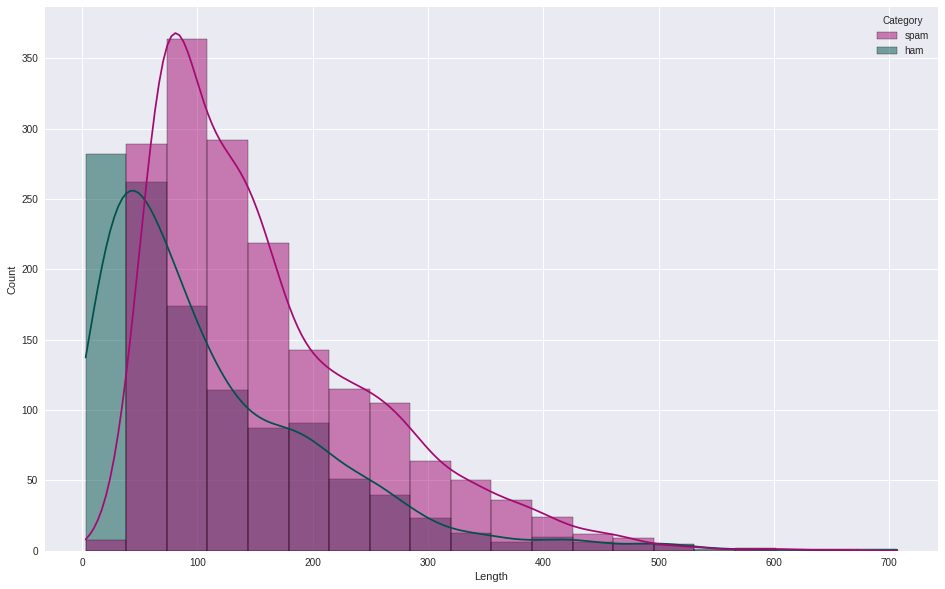

In [14]:
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(16,10))
sns.histplot(x = data["Length"], hue = data["Category"], kde=True, bins=20, palette=pal[:2]);

# <span style="color:#00525f;"> Word Cloud </span>

In [15]:
from wordcloud_fa import WordCloudFa
import re
import davat

In [16]:
spam_data = data[data.Category == 'spam']

In [17]:
spam_texts = "\n".join(re.sub(r"&[a-zA-Z]+", '', text) for text in spam_data['Message'])

In [18]:
wordcloud = WordCloudFa(no_reshape=True)

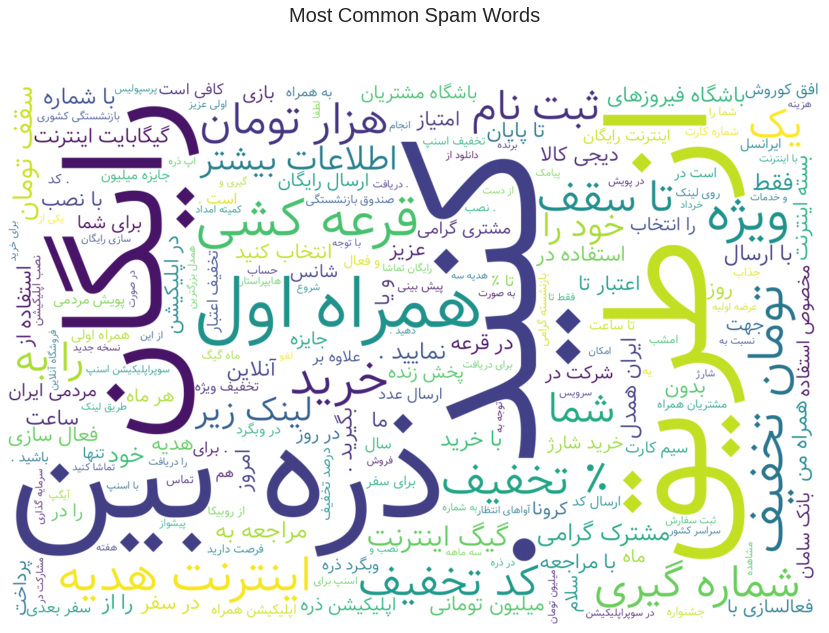

In [19]:
wordcloud = WordCloudFa(no_reshape=True, width=1200, height=800, background_color="white")
wc = wordcloud.generate(davat.clean(spam_texts, remove_punctuations=True))
spam_cloud = wc.to_image()
fig, ax = plt.subplots(figsize=(16,10))
plt.imshow(spam_cloud, interpolation='bilinear')
plt.title('Most Common Spam Words', fontsize=20, y=1.1)
plt.axis("off");
# image.save('persian-example.png')

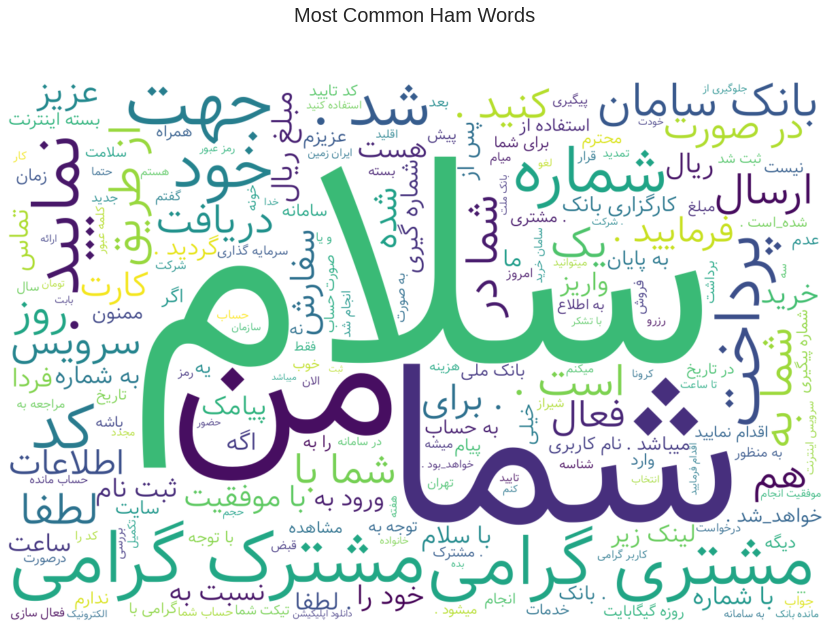

In [20]:
ham_data = data[data.Category == 'ham']

ham_text = " ".join(re.sub(r"&[a-zA-Z]+", '', text) for text in ham_data['Message'])


wordcloud = WordCloudFa(no_reshape=True, width=1200, height=800, background_color="white")
wc = wordcloud.generate(davat.clean(ham_text, remove_punctuations=True))
ham_cloud = wc.to_image()

fig, ax = plt.subplots(figsize=(16,10))
plt.imshow(ham_cloud, interpolation='bilinear')
plt.title('Most Common Ham Words', fontsize=20, y=1.1)
plt.axis("off");

# <span style="color:#00525f;"> Training Classifers </span>

In [21]:
# X data
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Message']).toarray()

In [22]:
# y data
y = data["Spam"]
y.head()

0    1
1    0
2    0
3    0
4    0
Name: Spam, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
from sklearn import metrics

# <span style="color:#00525f;"> Multinomial Naive Bayes </span>

In [25]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [26]:
MultinomialNBScore = nb.score(X_test, y_test)
print("Accuracy obtained by Multinomial Naive Bayes model:",MultinomialNBScore*100)

Accuracy obtained by Multinomial Naive Bayes model: 90.49255441008019


In [27]:
y_pred_nb = nb.predict(X_test)
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       333
           1       0.94      0.91      0.92       540

    accuracy                           0.90       873
   macro avg       0.90      0.90      0.90       873
weighted avg       0.91      0.90      0.91       873



In [28]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[23:47:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
XGBClassifierScore = xgb.score(X_test, y_test)
print("Accuracy obtained by XGBOOST model:",XGBClassifierScore*100)

Accuracy obtained by XGBOOST model: 92.55441008018327


In [30]:
y_pred_nb = xgb.predict(X_test)
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       333
           1       0.95      0.93      0.94       540

    accuracy                           0.93       873
   macro avg       0.92      0.93      0.92       873
weighted avg       0.93      0.93      0.93       873



# <span style="color:#00525f;"> Bernoulli Naive Bayes </span>

In [31]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB()

In [32]:
BernoulliNBScore = bnb.score(X_test, y_test)
print("Accuracy obtained by Bernoulli Naive Bayes model:",BernoulliNBScore*100)

Accuracy obtained by Bernoulli Naive Bayes model: 91.86712485681558


In [33]:
y_pred_bnb = bnb.predict(X_test)
print(metrics.classification_report(y_test, y_pred_bnb))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       333
           1       0.96      0.91      0.93       540

    accuracy                           0.92       873
   macro avg       0.91      0.92      0.92       873
weighted avg       0.92      0.92      0.92       873



# <span style="color:#00525f;"> Random Forest Classifier </span>

In [34]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [35]:
RandomForestClassifierScore = rfc.score(X_test, y_test)
print("Accuracy obtained by Random Forest Classifier model:",RandomForestClassifierScore*100)

Accuracy obtained by Random Forest Classifier model: 92.21076746849943


In [36]:
y_pred_rfc = rfc.predict(X_test)
print(metrics.classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       333
           1       0.94      0.93      0.94       540

    accuracy                           0.92       873
   macro avg       0.92      0.92      0.92       873
weighted avg       0.92      0.92      0.92       873



# <span style="color:#00525f;"> Decision Tree Classifier </span>

In [37]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state= 2)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2)

In [38]:
DecisionTreeClassifierScore = dtc.score(X_test,y_test)
print("Accuracy obtained by Decision Tree Classifier model:",DecisionTreeClassifierScore*100)

Accuracy obtained by Decision Tree Classifier model: 86.5979381443299


In [39]:
y_pred_dtc = dtc.predict(X_test)
print(metrics.classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       333
           1       0.90      0.88      0.89       540

    accuracy                           0.87       873
   macro avg       0.86      0.86      0.86       873
weighted avg       0.87      0.87      0.87       873



# <span style="color:#00525f;"> 2-layer neural network Classifier </span>

In [40]:
from sklearn.neural_network import MLPClassifier 
mlp= MLPClassifier(hidden_layer_sizes= (50,), activation= 'relu', solver= 'adam', alpha= 0.001, max_iter= 250, shuffle= True, random_state= 2)
mlp.fit(X_train, y_train)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(50,), max_iter=250,
              random_state=2)

In [41]:
MLPClassifierScore = mlp.score(X_test, y_test)
print("Accuracy obtained by 2-layer neural network Classifier model:",MLPClassifierScore*100)

Accuracy obtained by 2-layer neural network Classifier model: 93.12714776632302


In [42]:
y_pred_dtc = mlp.predict(X_test)
print(metrics.classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       333
           1       0.96      0.93      0.94       540

    accuracy                           0.93       873
   macro avg       0.92      0.93      0.93       873
weighted avg       0.93      0.93      0.93       873



# <span style="color:#00525f;"> support vector machine Classifier </span>

In [43]:
from sklearn.svm import LinearSVC
svm = LinearSVC(dual= False, fit_intercept= False, random_state= 2, max_iter= 250)
svm.fit(X_train, y_train)


LinearSVC(dual=False, fit_intercept=False, max_iter=250, random_state=2)

In [44]:
LinearSVCScore = svm.score(X_test, y_test)
print("Accuracy obtained by support vector machine model:",LinearSVCScore*100)

Accuracy obtained by support vector machine model: 89.8052691867125


In [45]:
y_pred_dtc = svm.predict(X_test)
print(metrics.classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       333
           1       0.92      0.91      0.92       540

    accuracy                           0.90       873
   macro avg       0.89      0.89      0.89       873
weighted avg       0.90      0.90      0.90       873



# <span style="color:#00525f;"> KNeighbors Classifier </span>

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [47]:
KNNScore = knn.score(X_test, y_test)
print("Accuracy obtained by KNeighbors Classifier model:",KNNScore*100)

Accuracy obtained by KNeighbors Classifier model: 63.80297823596792


In [48]:
y_pred_dtc = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.51      0.97      0.67       333
           1       0.96      0.44      0.60       540

    accuracy                           0.64       873
   macro avg       0.73      0.70      0.63       873
weighted avg       0.79      0.64      0.63       873



# <span style="color:#00525f;"> Plot Models Performances </span>

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


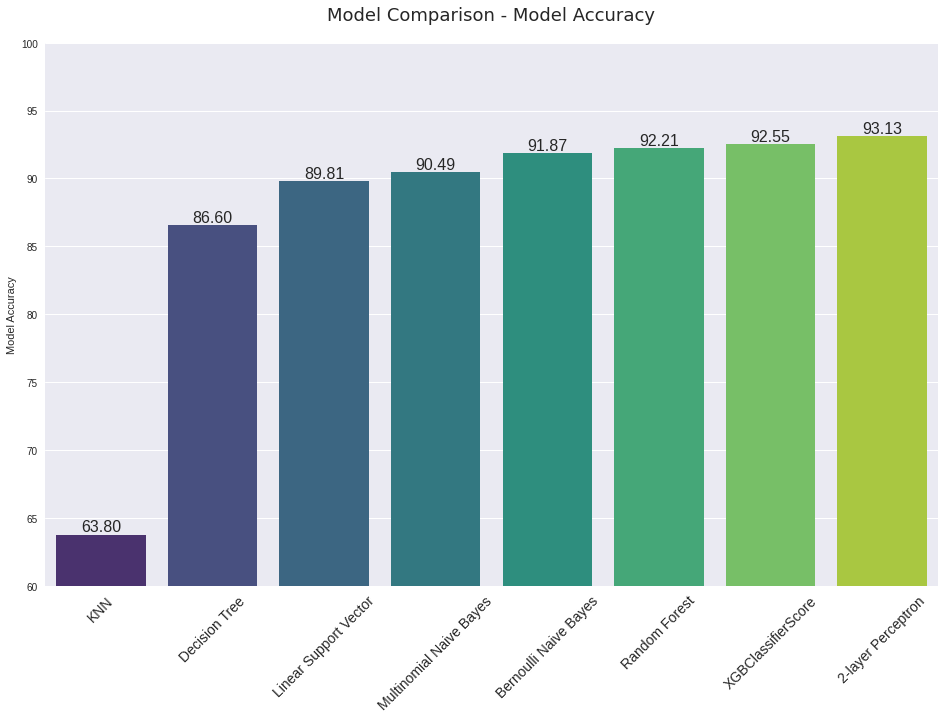

In [49]:
plt.style.use("seaborn")

scores = {"Multinomial Naive Bayes":MultinomialNBScore,
          "Bernoulli Naive Bayes": BernoulliNBScore,
          "Decision Tree": DecisionTreeClassifierScore, 
          "Random Forest": RandomForestClassifierScore,
          "2-layer Perceptron": MLPClassifierScore,
          "Linear Support Vector": LinearSVCScore,
          "KNN": KNNScore,
          "XGBClassifierScore": XGBClassifierScore
         }


scores = {k: v*100 for k, v in sorted(scores.items(), key=lambda item: item[1])}


x = list(scores.keys())

y = list(scores.values())


from matplotlib.ticker import FormatStrFormatter
        
fig, ax = plt.subplots(figsize=(16,10))
ax.set(ylim=[60, 100])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

splot = sns.barplot(x=x,y=y, palette="viridis", );
plt.bar_label(splot.containers[0], size=16, fmt='%.2f')
plt.ylabel("Model Accuracy")
plt.xticks(rotation=45, fontsize=14)
plt.title("Model Comparison - Model Accuracy", fontsize=18, fontname="Helvetica", y=1.03)
plt.show()